In [1]:
!pip install stable-baselines[mpi] #box2d, atari, robotics

     |████████████████████████████████| 245kB 5.2MB/s 
     |████████████████████████████████| 1.4MB 39.1MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065239 sha256=a7c6a64c861b80d266ff8f6b2efc78fb160ba24312b65e016ef4839fb1b0a1c7
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py


In [2]:
!pip install gym==0.18.0
!pip install atari-py==0.2.5

     |████████████████████████████████| 1.6MB 4.3MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656449 sha256=71d68be43a3b2076674279493e8e5fbd5e9e8b25edb9aa8eee2a9e904ad25565
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 2.8MB 5.3MB/s 
  Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [30]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 2s (381 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pack

In [39]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import Huber

import gym

import imageio

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
#from stable_baselines import PPO2
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind

%matplotlib inline

DQN.  CHOPPER.

In [5]:
# Параметры конфигурации
seed = 17
discount_past_rewards = 0.99   # дисконт для прошлых вознаграждений
reward_param = 1.0             # Параметр вознаграждения
reward_param_min = 0.1         # Параметр минимального вознаграждения
reward_param_max = 1.0         # Параметр максимального вознаграждения
reward_interval = reward_param_max - reward_param_min  # интервал снижения вероятности случайных действий
n_actions = 4                   # количество возможных действий
batch_size = 32                # размер пакета из буфера воспроизведения
max_steps_episode = 10000       # максимальное количество шагов за эпизод 10000

In [6]:
# Базовая среда
env = make_atari('BreakoutNoFrameskip-v4')
#env = gym.make('SpaceInvaders-v0')     #    CarRacing-v0 SpaceInvaders-v0 MountainCar-v0 Pong-v0 ChopperCommand-v0

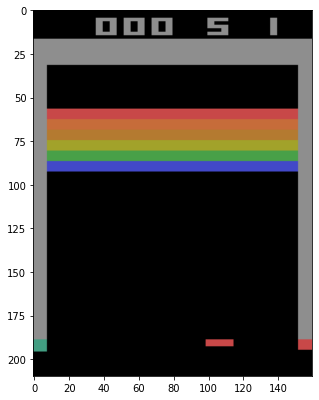

In [7]:
# Первоначальная картинка игры
game = env.reset()

plt.figure(figsize=(5, 10))
plt.imshow(game)
plt.show()

In [8]:
# Изменение кадров: оттенки серого, разбивка кадров и масштабирование до меньшего соотношения
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

[17, 767166449]

In [9]:
# Смотрим данные env для подачи в нейронную сеть
env.observation_space

Box(0.0, 255.0, (84, 84, 4), float32)

In [10]:
# Создаем нейронную сеть из статьи Deepmind
def create_chopper_net():
    inputs = Input(shape=(84, 84, 4,))
    chop1 = Conv2D(32, 8, strides=4, activation='relu')(inputs)
    chop2 = Conv2D(64, 4, strides=2, activation='relu')(chop1)
    chop3 = Conv2D(64, 3, strides=1, activation='relu')(chop2)
    chop4 = Flatten()(chop3)
    chop5 = Dense(512, activation='relu')(chop4)

    chop_action = Dense(n_actions, activation='linear')(chop5)

    return Model(inputs = inputs, outputs=chop_action)


In [11]:
# модель для значений, которые используются для совершения действия
chopper = create_chopper_net()

In [12]:
# целевая модель для предсказания будущих вознаграждений
target_chopper = create_chopper_net()

In [13]:
chopper.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052  

In [14]:
# используем Adam, для сокращения времени тренировки
optimizer = Adam(learning_rate=0.00025, clipnorm=1.0)   # 0.0001

In [15]:
# Функция потерь
loss_function = Huber()

In [16]:
# Создаем среду
action_history = []
state_history = []
state_next_history = []
reward_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

In [17]:
count_random_frames = 50000   # 50000   # Количество кадров для выполнения случайных действий
count_intelligence_frames = 100000.0    # 1000000.0 # Количество кадров для сбора информации
max_repeat_length = 20000   # 100000         # Максимальное число повторов
learn_n_action = 4                           # Обучаем модель 4 действиям
update_target_chopper = 2000   # 10000      # Частота обновления целевой сети

In [19]:
# Генерация игровых эпизодов
while True:
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_episode):
        #env.render()
        frame_count += 1
        
        # случайное действие
        if frame_count < count_random_frames or reward_param > np.random.rand(1)[0]:
            action = np.random.choice(n_actions)
        
        # Предсказание действий по состоянию среды
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = chopper(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()   # берем лучшее действие
        
        # Уменьшаем вероятность случайного действия
        reward_param -= reward_interval / count_intelligence_frames
        reward_param = max(reward_param, reward_param_min)
        
        # Применяем в текущей среде
        state_next, reward, done, _  = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward

        # Сохраняем действие, состояние и награду
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        reward_history.append(reward)
        state = state_next

        # Обновляем каждый 4 кадр
        if frame_count % learn_n_action == 0 and len(done_history) > batch_size:
            # Получить индексы образцов
            indexes = np.random.choice(range(len(done_history)), size=batch_size)
            # Используем образцы списков
            state_sample = np.array([state_history[i] for i in indexes])
            state_next_sample = np.array([state_next_history[i] for i in indexes])
            reward_sample = [reward_history[i] for i in indexes]
            action_sample = [action_history[i] for i in indexes]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indexes])

            # Создаем обнавленные значения для будущих состояний и используем целевую модель для стабильности
            future_rewards = target_chopper.predict(state_next_sample)
            updated_future_values = reward_sample + discount_past_rewards * tf.reduce_max(future_rewards, axis=1)

            # Если последний кадр установливаем последнее значение на -1
            updated_future_values = updated_future_values * (1 - done_sample) - done_sample
            # Создаем маску, для рассчета потерь только по обновленным значениям
            mask = tf.one_hot(action_sample, n_actions)

            with tf.GradientTape() as tape:
                # Обучаем модель по состояниям и обновленным значениям
                learn_values = chopper(state_sample)
                # Применяем маски
                learn_action = tf.reduce_sum(tf.multiply(learn_values, mask), axis=1)
                # Рассчитываем потери
                loss = loss_function(updated_future_values, learn_action)

            # Backpropagetion-Обратное расространение ошибки
            grads = tape.gradient(loss, chopper.trainable_variables)
            optimizer.apply_gradients(zip(grads, chopper.trainable_variables))

        if frame_count % update_target_chopper == 0:
            # обновляем целевую сеть новыми весами
            target_chopper.set_weights(chopper.get_weights())
            template = 'Текущая награда: {:.2f} в эпизоде {}, количество кадров {}'
            print(template.format(running_reward, episode_count, frame_count))

        # Ограничиваем историю действий, состояний и вознаграждений 
        if len(reward_history) > max_repeat_length:
            del reward_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Обновляем текущую награду, чтобы проверить условие для решения
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1
    
    # Условие при котором задание считается выполненным
    if running_reward > 5:   # 40
        print(f'Задание решено в эпизоде: {episode_count}!')
        break


Задание решено в эпизоде: 3035!


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
chopper.save('/content/drive/MyDrive/UAI/save_nets/chopper.h5')

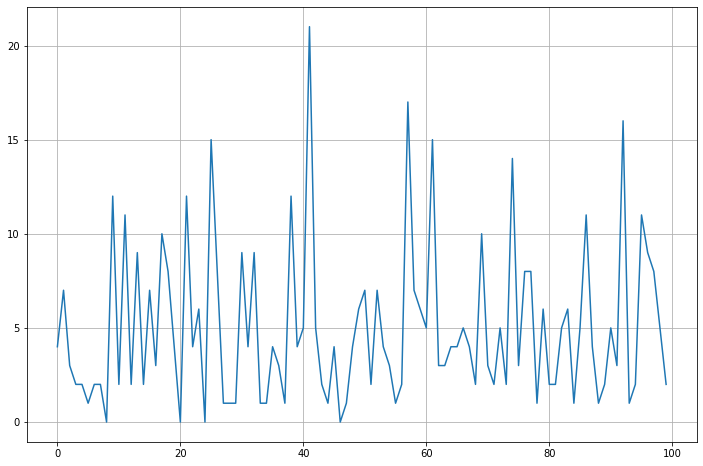

In [23]:
# График распределения наград
plt.figure(figsize=(12, 8))
plt.plot(episode_reward_history,'-')
ax = plt.gca()
ax.grid(True)
plt.show()